# Test on a pretrained model

In this notebook we will use the pretrained model ```coronal_depth_matching.h5``` to perform some testing using as reference atlases CCFv3, CCFv2, and P56 and as a test atlas BrainMaps wich wasn't used at training time.

In [1]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from data_generator import *
from models import *
from utils import *

base_fld = './brain_images'
assert os.path.isdir(base_fld)

After the imports the first thing that we want to do is to instantiate the database and the generator of the brain images. To do that make sure you have populated ```brain_images``` following the correct directory structure. Then we load the pretrained Siamese Network model and we print its content.

In [2]:
new_dataframe = BaseBrainDataset(base_folder=base_fld, reshape_to=(224,224))
data_gen = DataGenerator(base_folder=base_fld, reshape_to=(224, 224), batch_size=8)

In [3]:
path = './coronal_depth_matching.h5'
siamese_net = get_model()
siamese_net.load_weights(path)
siamese_net.summary()

Model: "siamese_network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_pair_input (InputLayer)   [(None, 2, 224, 224, 0                                            
__________________________________________________________________________________________________
siamese_branch_1 (Lambda)       (None, 224, 224, 3)  0           image_pair_input[0][0]           
__________________________________________________________________________________________________
siamese_branch_2 (Lambda)       (None, 224, 224, 3)  0           image_pair_input[0][0]           
__________________________________________________________________________________________________
densenet121 (Functional)        (None, 7, 7, 1024)   7037504     siamese_branch_1[0][0]           
                                                                 siamese_branch_2[0]

To see what kind of images the network has been trained on we sample some couples using the DataGenerator and we plot them together with their associated label. The label is a number between 0 and 1 indicating the depth difference between the two images (0 means they are at the same depth, 1 means they are at the opposite sides of the brain). Notice also the augmentations such as blurring, color shifting and noise that are applied to these images at train time to increase the generality of the model.

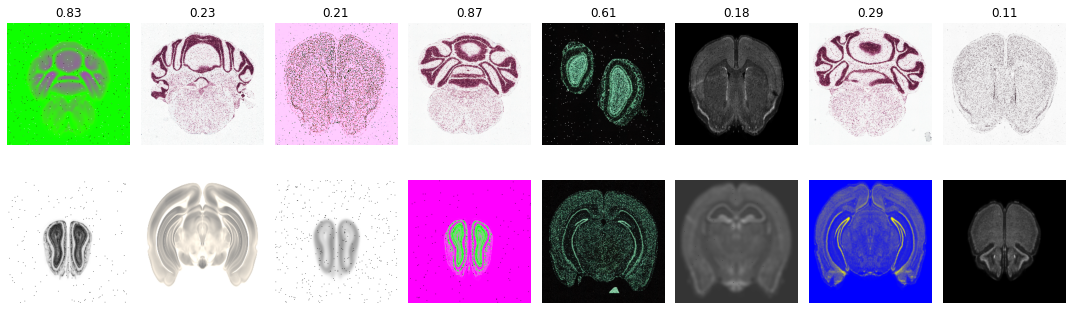

In [4]:
x_btc, y_btc = data_gen[0]
fig, axs = plt.subplots(nrows=2, ncols=8, figsize=(15, 5))
for img_pair, ax_row, y in zip(x_btc, axs.T, y_btc):
    ax_row[0].axis('off')
    ax_row[0].imshow(img_pair[0])
    ax_row[0].set_title('{:.2f}'.format(y))
    ax_row[1].axis('off')
    ax_row[1].imshow(img_pair[1])
plt.tight_layout()

We create the latent space of the three reference atlases and save each of them in a pickle file so to have a faster prediction time later.
Then we plot an UMAP representation of the latent space of the three reference atlases. The green markers represent one test image and its best matches in the three reference atlases. Notice the quasi-1D structure of the latent space representing the associated depth and the separation between different brain regions.

In [5]:
save_latent_space(new_dataframe, siamese_net, atlas='ccfv3')
save_latent_space(new_dataframe, siamese_net, atlas='ccfv2')
save_latent_space(new_dataframe, siamese_net, atlas='p56')

/home/lbuffoni/anaconda3/envs/oneshot/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/lbuffoni/anaconda3/envs/oneshot/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/lbuffoni/anaconda3/envs/oneshot/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


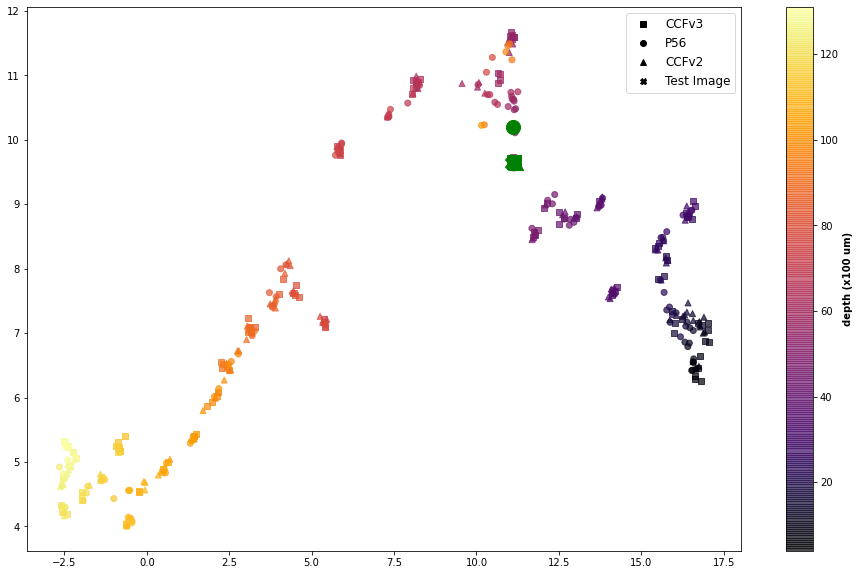

In [4]:
plot_umap(new_dataframe, siamese_net)

Finally we plot a prediction of a random image from BrainMaps and we match it againts the atlas of our choice. Here you can see the predictions of the model and the piecewise linear fit that can be done to smooth out the outliers. On the right the original sampled image and its best match in the atlas.

/home/lbuffoni/anaconda3/envs/oneshot/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


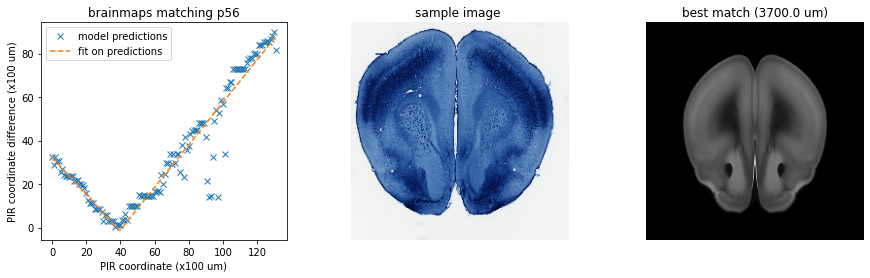

In [5]:
_ = plot_predictions(siamese_net=siamese_net, data_frame=new_dataframe, test_atlas='brainmaps', reference_atlas='p56')